In [19]:
from qiskit_aer.primitives import SamplerV2
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit import QuantumCircuit
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms import QAOA
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit_aer import AerSimulator
import numpy as np

In [20]:
from qiskit.quantum_info import SparsePauliOp

def build_allocation_paulis(num_servers, num_users, user_requests):
    """
    Convert user requests to Pauli list for server allocation.

    Args:
    num_servers (int): Number of servers.
    num_users (int): Number of users.
    user_requests (list): User-service requests (user_id, service_id, server_id).

    Returns:
    list[tuple[str, float]]: Pauli list for allocation Hamiltonian.
    """
    pauli_list = []
    for user_request in user_requests:
        user_id, service_id, server_id = user_request

        # Create Pauli string for server-user connection
        paulis = ["I"] * num_servers
        paulis[server_id] = "Z"

        # Weight represents connection cost or penalty
        weight = 1  # Adjust according to problem requirements

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list

# Define problem parameters
num_servers = 5
num_users = 10
user_requests = [
    (0, 0, 0),  # User 0 requests service 0 from server 0
    (1, 1, 1),
    (2, 0, 2),
    # Add more user requests...
]

allocation_paulis = build_allocation_paulis(num_servers, num_users, user_requests)

allocation_hamiltonian = SparsePauliOp.from_list(allocation_paulis)
print("Allocation Hamiltonian:", allocation_hamiltonian)

Allocation Hamiltonian: SparsePauliOp(['IIIIZ', 'IIIZI', 'IIZII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j])


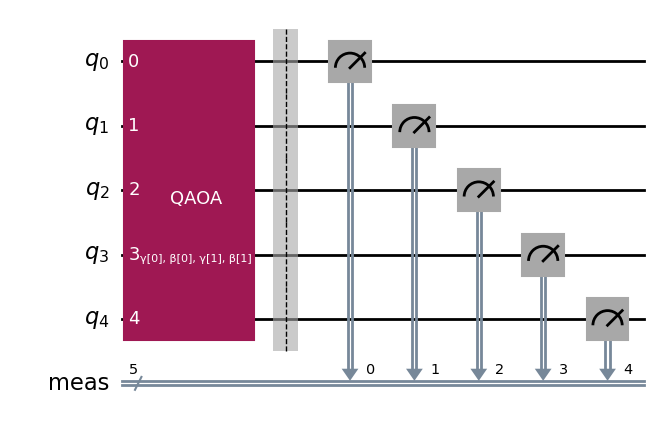

In [21]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=allocation_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

In [22]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

In [23]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    """
    Estimates the cost function for the given parameters.

    Args:
    params (numpy.array): Ansatz parameters.
    ansatz (QuantumCircuit): Parametrized quantum circuit.
    hamiltonian (SparsePauliOp): Problem Hamiltonian.
    estimator (Estimator): Quantum estimator.

    Returns:
    float: Estimated cost value.
    """

    # Map virtual qubits to physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    # Prepare estimator input
    pub = (ansatz, isa_hamiltonian, params)

    # Run estimator
    job = estimator.run([pub])

    # Extract result
    result = job.result()[0]
    cost = result.data.evs[0].real  # Consider real part of expectation value

    # Record cost for tracking convergence
    objective_func_vals.append(cost)

    return cost

In [25]:
# Define the ansatz (parametrized quantum circuit)
def allocate_ansatz(params, num_servers):
    qc = QuantumCircuit(num_servers)
    for i in range(num_servers):
        qc.ry(params[i], i)
    return qc


In [37]:

# Define the cost function estimator
def cost_func_estimator(params, num_servers, allocation_hamiltonian):
    ansatz = allocate_ansatz(params, num_servers)
    estimator = Estimator()
    job = estimator.run([ansatz])
    result = job.result()[0]
    cost = result.expectation_value.real
    objective_func_vals.append(cost)
    return cost


In [39]:

# Initial parameters
num_servers = 5
init_params = np.array([0.5] * num_servers)

# Optimization bounds
bounds = [(0, np.pi)] * num_servers

# Optimize
result = minimize(
    lambda params: cost_func_estimator([params, num_servers, allocation_hamiltonian]),
    init_params,
    method="COBYLA",
    bounds=bounds,
)

print("Optimal Parameters:", result.x)
print("Minimum Cost:", result.fun)

TypeError: cost_func_estimator() missing 2 required positional arguments: 'num_servers' and 'allocation_hamiltonian'